# Stock Price Predictor
Data until July 19 ist analyzed. Data from September is treated as Ground Truth, so that we can visualize the predicted vs. the true curve of that month

In [0]:
import numpy as np
import sklearn
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set()

In [0]:
!pip install  yfinance --upgrade --no-cache-dir

In [0]:
#Loading Yahoo Finance dataset
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()


In [148]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2019, 8, 1)
df_full = pdr.get_data_yahoo("AAPL", start, end).reset_index()
df_full.to_csv('AAPL.csv',index=False)
df_full.set_index('Date', inplace=True)


# loading a ground truth data set.
# TODO: Cleaner code
start_gt = start = datetime.datetime(2015,1,1)
end_gt = datetime.datetime(2019, 9, 1)
df_gt = pdr.get_data_yahoo("AAPL", start_gt, end_gt).reset_index()
df_gt.to_csv('AAPL.csv',index=False)
df_gt.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [0]:
# Find rolling mean and plot it
close_px = df_full['Adj Close']
mavg = close_px.rolling(window=100).mean()

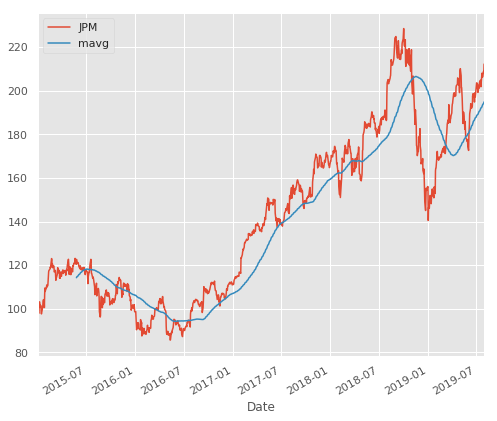

In [130]:
from matplotlib import style

import matplotlib as mpl
mpl.rc('figure',figsize=(8,7))
mpl.__version__

style.use('ggplot')

close_px.plot(label='JPM')
mavg.plot(label='mavg')
plt.legend()


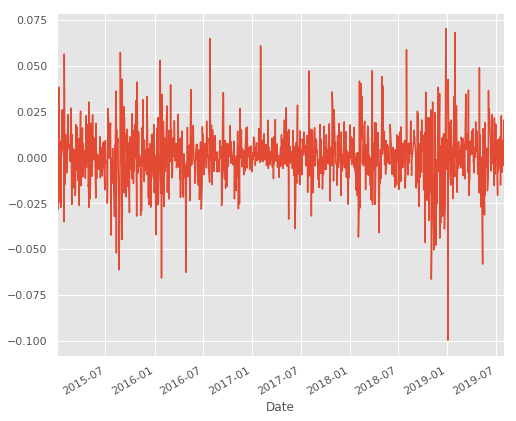

In [131]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [132]:
# Analyzing Competitor Stocks
dfcomp = pdr.get_data_yahoo(['AAPL','GE','GOOG','IBM','MSFT'], start="2017-01-01").reset_index()['Adj Close']
dfcomp.to_csv('Comp.csv',index=False)

[*********************100%***********************]  5 of 5 downloaded


In [0]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

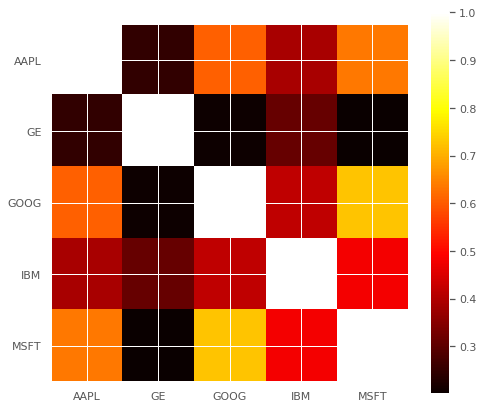

In [134]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

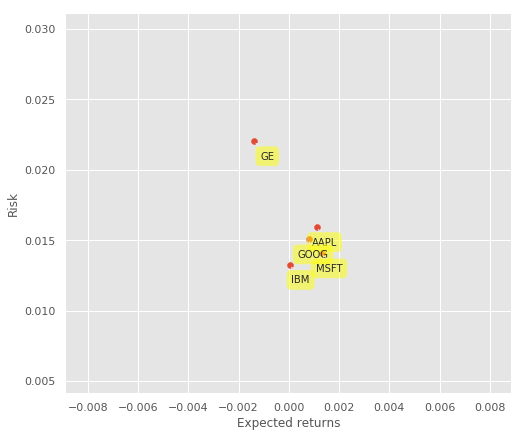

In [135]:
#extracting the average of returns and standard deviation of risk for each stock
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
#Engineering some features for the algorithms: High Low Percentage and Percentage Change
df = df_full.copy()
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
import math
from sklearn import preprocessing
dfreg.fillna(value = -99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(dfreg)))
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'],1))

X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(dfreg['label'])
y = y[:-forecast_out]

dfreg_backup = dfreg.copy()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [0]:
# It is important here not to shuffle because this is a time series dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, shuffle=False)

In [140]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [141]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [142]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [157]:
# Lasso
clflas = Lasso()
clflas.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [158]:
# Ridge
clfrdg = Ridge()
clfrdg.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [160]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencelas = clflas.score(X_test, y_test)
confidencerdg = clfrdg.score(X_test, y_test)
print(f'The linear regression confidence is {confidencereg}')
print(f'The quadratic regression 2 confidence is {confidencepoly2}')
print(f'The quadratic regression 3 confidence is {confidencepoly3}')
print(f'The lasso confidence is {confidencelas}')
print(f'The ridge confidence is {confidencerdg}')

The linear regression confidence is 0.648013105099692
The quadratic regression 2 confidence is 0.6773613548911446
The quadratic regression 3 confidence is 0.7009746063803738
The lasso confidence is 0.5979389094278729
The ridge confidence is 0.641546165289024


In [0]:
def forecast_plot(clf, title):
  forecast = clf.predict(X_lately)
  dfreg = dfreg_backup.copy()
  dfreg['Forecast'] = np.nan
  last_date = dfreg.iloc[-1].name
  last_unix = last_date
  next_unix = last_unix + datetime.timedelta(days=1)

  for i in forecast: 
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
      
  n_range=100
  df_gt['Adj Close'].tail(n_range).plot()
  dfreg['Forecast'].tail(n_range).plot()
  plt.title(title)
  plt.legend(loc=4)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.show()

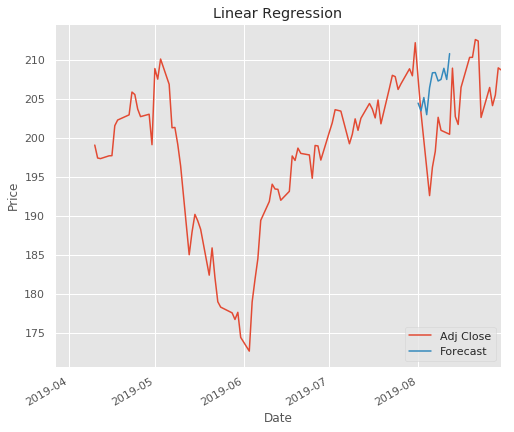

In [197]:
forecast_plot(clfreg, 'Linear Regression')

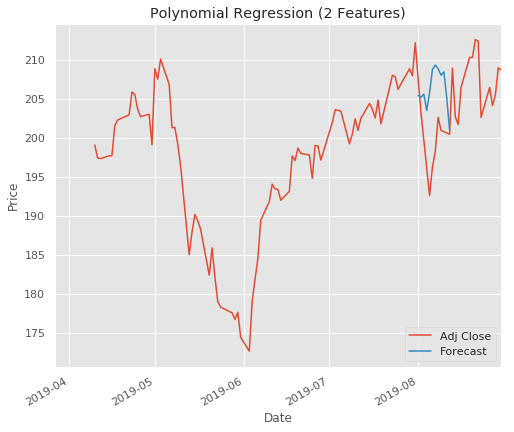

In [198]:
forecast_plot(clfpoly2, 'Polynomial Regression (2 Features)')

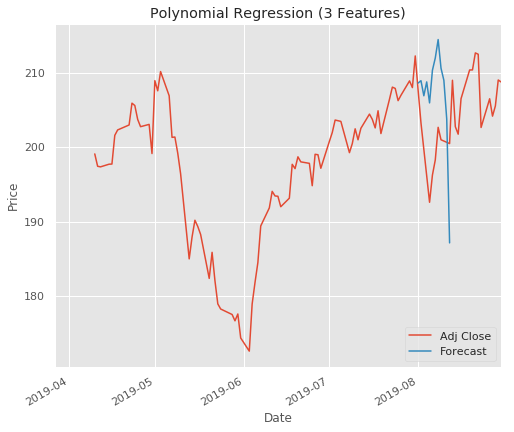

In [199]:
forecast_plot(clfpoly3, 'Polynomial Regression (3 Features)')

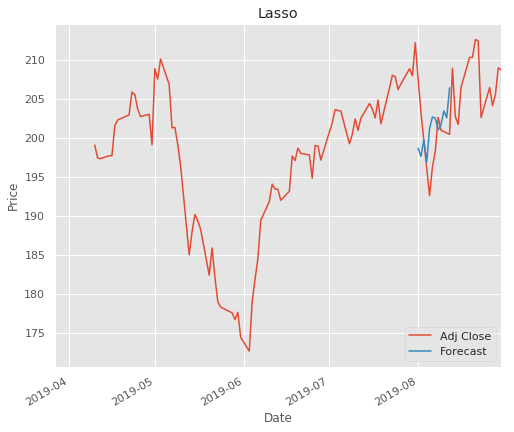

In [200]:
forecast_plot(clflas, 'Lasso')

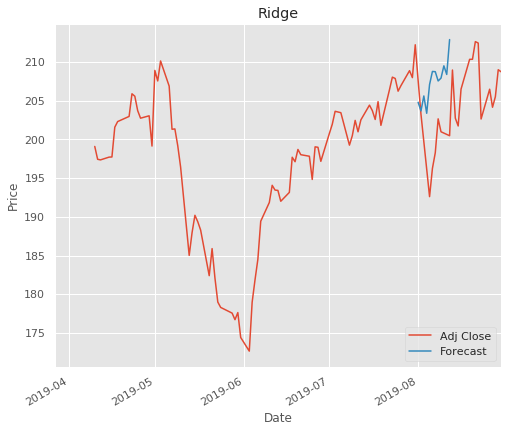

In [201]:
forecast_plot(clfrdg, 'Ridge')